In [1]:
!pip install google-play-scraper

     ---------------------------------------- 0.0/50.2 kB ? eta -:--:--
     -------- ------------------------------- 10.2/50.2 kB ? eta -:--:--
     ----------------------- -------------- 30.7/50.2 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 50.2/50.2 kB 367.0 kB/s eta 0:00:00


In [2]:
import google_play_scraper

In [5]:
app_id = 'com.openai.chatgpt'

In [6]:
from google_play_scraper import Sort
from google_play_scraper.constants.element import ElementSpecs
from google_play_scraper.constants.regex import Regex
from google_play_scraper.constants.request import Formats
from google_play_scraper.utils.request import post

import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import json
from time import sleep
from typing import List, Optional, Tuple

In [10]:
MAX_COUNT_EACH_FETCH = 199


class _ContinuationToken:
    __slots__ = (
        "token",
        "lang",
        "country",
        "sort",
        "count",
        "filter_score_with",
        "filter_device_with",
    )

    def __init__(
        self, token, lang, country, sort, count, filter_score_with, filter_device_with
    ):
        self.token = token
        self.lang = lang
        self.country = country
        self.sort = sort
        self.count = count
        self.filter_score_with = filter_score_with
        self.filter_device_with = filter_device_with


def _fetch_review_items(
    url: str,
    app_id: str,
    sort: int,
    count: int,
    filter_score_with: Optional[int],
    filter_device_with: Optional[int],
    pagination_token: Optional[str],
):
    dom = post(
        url,
        Formats.Reviews.build_body(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            "null" if filter_device_with is None else filter_device_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )
    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-2][-1]


def reviews(
    app_id: str,
    lang: str = "en",
    country: str = "us",
    sort: Sort = Sort.MOST_RELEVANT,
    count: int = 100,
    filter_score_with: int = None,
    filter_device_with: int = None,
    continuation_token: _ContinuationToken = None,
) -> Tuple[List[dict], _ContinuationToken]:
    sort = sort.value

    if continuation_token is not None:
        token = continuation_token.token

        if token is None:
            return (
                [],
                continuation_token,
            )

        lang = continuation_token.lang
        country = continuation_token.country
        sort = continuation_token.sort
        count = continuation_token.count
        filter_score_with = continuation_token.filter_score_with
        filter_device_with = continuation_token.filter_device_with
    else:
        token = None

    url = Formats.Reviews.build(lang=lang, country=country)

    _fetch_count = count

    result = []

    while True:
        if _fetch_count == 0:
            break

        if _fetch_count > MAX_COUNT_EACH_FETCH:
            _fetch_count = MAX_COUNT_EACH_FETCH

        try:
            review_items, token = _fetch_review_items(
                url,
                app_id,
                sort,
                _fetch_count,
                filter_score_with,
                filter_device_with,
                token,
            )
        except (TypeError, IndexError):
            #funnan MOD start
            token = continuation_token.token
            continue
            #MOD end

        for review in review_items:
            result.append(
                {
                    k: spec.extract_content(review)
                    for k, spec in ElementSpecs.Review.items()
                }
            )

        _fetch_count = count - len(result)

        if isinstance(token, list):
            token = None
            break

    return (
        result,
        _ContinuationToken(
            token, lang, country, sort, count, filter_score_with, filter_device_with
        ),
    )


def reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list:
    kwargs.pop("count", None)
    kwargs.pop("continuation_token", None)

    continuation_token = None

    result = []

    while True:
        _result, continuation_token = reviews(
            app_id,
            count=MAX_COUNT_EACH_FETCH,
            continuation_token=continuation_token,
            **kwargs
        )

        result += _result

        if continuation_token.token is None:
            break

        if sleep_milliseconds:
            sleep(sleep_milliseconds / 1000)

    return result

In [7]:
reviews_count = 10000

In [11]:
result = []
continuation_token = None


with tqdm(total=reviews_count, position=0, leave=True) as pbar:
    while len(result) < reviews_count:
        new_result, continuation_token = reviews(
            app_id,
            continuation_token=continuation_token,
            lang='en', #The language of review
            country='in', #Country for which you want to scrape 
            sort=Sort.NEWEST,
            filter_score_with=None,
            count=199 #No need to change this
        )
        if not new_result:
            break
        result.extend(new_result)
        pbar.update(len(new_result))

10149it [01:22, 122.62it/s]                                                                                            


In [12]:
df = pd.DataFrame(result)

In [13]:
df.shape

(10149, 11)

In [14]:
df.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,b4805753-9d04-499d-ac76-5c022c1de053,jaya ram,https://play-lh.googleusercontent.com/a-/ALV-U...,good,5,0,1.2024.122,2024-05-12 22:21:54,None,None,1.2024.122
1,621a2aa6-5f26-4f33-a9b1-5f27a778c530,Syed Muhammad,https://play-lh.googleusercontent.com/a-/ALV-U...,It soles all my questions correctly,5,0,1.2024.122,2024-05-12 22:20:43,None,None,1.2024.122
2,9a601bbb-f580-4937-86f3-34621a81ecc0,Mohammed Ghouse,https://play-lh.googleusercontent.com/a-/ALV-U...,the best,5,0,1.2024.122,2024-05-12 22:19:15,None,None,1.2024.122
3,c3c5b28f-a4a5-4395-84fc-c98ab8805767,Sophia Fullagar,https://play-lh.googleusercontent.com/a/ACg8oc...,tastes like cheese 😋,4,0,1.2024.115,2024-05-12 22:13:59,None,None,1.2024.115
4,b87ad476-b99c-451d-83e5-ee83f0cc5e6d,KHUSHBU KUMARI,https://play-lh.googleusercontent.com/a-/ALV-U...,most productive and helpful answer,5,0,1.2024.122,2024-05-12 22:13:27,None,None,1.2024.122
5,cd5a77f0-3304-4557-94db-fe084b3fcf5d,Md Shakib,https://play-lh.googleusercontent.com/a-/ALV-U...,Ab mai kya bolo! Ai to life easy kar diya hai ...,5,0,None,2024-05-12 22:11:50,None,None,None
6,6f706309-131d-4c3b-85df-c79cb96f8ce6,Huck Shwilly,https://play-lh.googleusercontent.com/a-/ALV-U...,I paid 19.99 and my subscription hasn't update...,1,0,1.2024.122,2024-05-12 22:07:40,None,None,1.2024.122
7,a3acc820-4eb3-4291-8278-9883cbcb279f,Andrew Ehab,https://play-lh.googleusercontent.com/a/ACg8oc...,It's perfect,5,0,1.2024.122,2024-05-12 22:04:29,None,None,1.2024.122
8,cf091d55-a579-43da-ab86-f38a9803a9d5,Ankush Mondal,https://play-lh.googleusercontent.com/a-/ALV-U...,👍 good,5,0,1.2024.122,2024-05-12 22:01:53,None,None,1.2024.122
9,08e0d963-22c6-476c-8180-8cfd69fc9231,Jagadhish Kenguva,https://play-lh.googleusercontent.com/a/ACg8oc...,good,5,0,1.2024.122,2024-05-12 21:58:27,None,None,1.2024.122


In [15]:
df.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')

In [16]:
df = df[['reviewId', 'userName', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'appVersion']]

In [18]:
import datetime 

In [19]:
today = datetime.date.today()

yesterday = today - datetime.timedelta(days=1)

print(yesterday)

2024-05-12


In [20]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,b4805753-9d04-499d-ac76-5c022c1de053,jaya ram,good,5,0,1.2024.122,2024-05-12 22:21:54,1.2024.122
1,621a2aa6-5f26-4f33-a9b1-5f27a778c530,Syed Muhammad,It soles all my questions correctly,5,0,1.2024.122,2024-05-12 22:20:43,1.2024.122
2,9a601bbb-f580-4937-86f3-34621a81ecc0,Mohammed Ghouse,the best,5,0,1.2024.122,2024-05-12 22:19:15,1.2024.122
3,c3c5b28f-a4a5-4395-84fc-c98ab8805767,Sophia Fullagar,tastes like cheese 😋,4,0,1.2024.115,2024-05-12 22:13:59,1.2024.115
4,b87ad476-b99c-451d-83e5-ee83f0cc5e6d,KHUSHBU KUMARI,most productive and helpful answer,5,0,1.2024.122,2024-05-12 22:13:27,1.2024.122


In [21]:
df['at'].iloc[0].date()


datetime.date(2024, 5, 12)

In [22]:
new_df = df[df['at'].dt.date == yesterday]


In [23]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 638 entries, 0 to 637
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              638 non-null    object        
 1   userName              638 non-null    object        
 2   content               638 non-null    object        
 3   score                 638 non-null    int64         
 4   thumbsUpCount         638 non-null    int64         
 5   reviewCreatedVersion  605 non-null    object        
 6   at                    638 non-null    datetime64[ns]
 7   appVersion            605 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 44.9+ KB


In [24]:
new_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,b4805753-9d04-499d-ac76-5c022c1de053,jaya ram,good,5,0,1.2024.122,2024-05-12 22:21:54,1.2024.122
1,621a2aa6-5f26-4f33-a9b1-5f27a778c530,Syed Muhammad,It soles all my questions correctly,5,0,1.2024.122,2024-05-12 22:20:43,1.2024.122
2,9a601bbb-f580-4937-86f3-34621a81ecc0,Mohammed Ghouse,the best,5,0,1.2024.122,2024-05-12 22:19:15,1.2024.122
3,c3c5b28f-a4a5-4395-84fc-c98ab8805767,Sophia Fullagar,tastes like cheese 😋,4,0,1.2024.115,2024-05-12 22:13:59,1.2024.115
4,b87ad476-b99c-451d-83e5-ee83f0cc5e6d,KHUSHBU KUMARI,most productive and helpful answer,5,0,1.2024.122,2024-05-12 22:13:27,1.2024.122


In [25]:
new_df.shape

(638, 8)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10149 entries, 0 to 10148
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              10149 non-null  object        
 1   userName              10149 non-null  object        
 2   content               10149 non-null  object        
 3   score                 10149 non-null  int64         
 4   thumbsUpCount         10149 non-null  int64         
 5   reviewCreatedVersion  9731 non-null   object        
 6   at                    10149 non-null  datetime64[ns]
 7   appVersion            9731 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 634.4+ KB


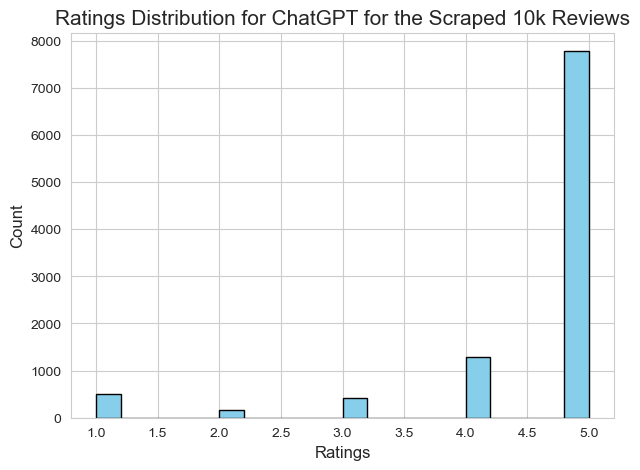

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize = (7,5))
plt.hist(df.score, bins=20, color = 'skyblue', edgecolor='black')
plt.title('Ratings Distribution for ChatGPT for the Scraped 10k Reviews', fontsize=15)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()